In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import time

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (AdaBoostClassifier,
                              BaggingClassifier,
                              ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              VotingClassifier,
                              StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             auc,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score,
                             roc_auc_score,
                             roc_curve)
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [4]:
df = pd.read_csv("../data/external/Hotel Reservations.csv")

# 🇺🇸 Modeling Data - 🇧🇷 Modelando os Dados



## Label Encoder

🇺🇸 Label Encoding is a data preprocessing technique that converts categorical values (such as text or labels) into numerical values. This is useful because most machine learning algorithms require numerical input to work properly.

🇧🇷 O Label Encoding é uma técnica de pré-processamento de dados que converte valores categóricos (como textos ou rótulos) em valores numéricos. Isso é útil porque a maioria dos algoritmos de machine learning requer dados numéricos para funcionar corretamente.

In [5]:
label_encoder = LabelEncoder()
for col in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']:
    df[col] = label_encoder.fit_transform(df[col])

In [6]:
X = df.drop(['booking_status', 'Booking_ID'], axis=1)
y = df['booking_status']

## Over Sample

🇺🇸 Over Sampling is a technique used to deal with imbalanced datasets, where one class has significantly fewer examples than the other. This imbalance can hurt the performance of machine learning models, as they tend to favor the majority class.
The idea of Over Sampling is to increase the number of samples from the minority class, either by duplicating existing samples or by generating new synthetic ones (such as with the SMOTE algorithm), until both classes are more balanced. This helps the model learn patterns from both classes and improves its ability to generalize.

🇧🇷 O Over Sampling (ou superamostragem) é uma técnica usada para lidar com conjuntos de dados desbalanceados, onde uma das classes possui muito menos exemplos do que a outra. Esse desequilíbrio pode prejudicar o desempenho de modelos de machine learning, pois eles tendem a favorecer a classe majoritária.
Com o Over Sampling, a ideia é aumentar a quantidade de exemplos da classe minoritária, gerando cópias ou criando novos exemplos sintéticos (como com o algoritmo SMOTE), até que haja um equilíbrio entre as classes. Isso ajuda o modelo a aprender melhor os padrões das duas classes e melhorar sua capacidade de generalização.


In [7]:
oversample = SMOTE(random_state=42)
over_X, over_y = oversample.fit_resample(X, y)

In [8]:
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(
    over_X, over_y, test_size=0.2, stratify=over_y, random_state=42
)

## Standard Scaler

🇺🇸 Standard Scaler is a normalization technique that transforms the data so that it has a mean of 0 and a standard deviation of 1. This is done by subtracting the mean and dividing by the standard deviation for each numeric column.
This scaling is important because many machine learning algorithms (such as logistic regression, SVM, KNN, and neural networks) are sensitive to the scale of the data. By applying the Standard Scaler, we ensure that all variables contribute equally during training, preventing variables with larger values from dominating the learning process.

🇧🇷 O Standard Scaler é uma técnica de normalização que transforma os dados para que tenham média igual a 0 e desvio padrão igual a 1. Isso é feito subtraindo a média e dividindo pelo desvio padrão de cada coluna numérica.
Essa padronização é importante porque muitos algoritmos de machine learning (como regressão logística, SVM, KNN e redes neurais) são sensíveis à escala dos dados. Ao aplicar o Standard Scaler, garantimos que todas as variáveis tenham o mesmo peso na hora de treinar o modelo, evitando que variáveis com valores maiores dominem o aprendizado.

In [9]:
scaler = StandardScaler()
over_X_train = scaler.fit_transform(over_X_train)
over_X_test = scaler.transform(over_X_test)

## Training Models - Treinando os Modelos

In [10]:
models = [
    AdaBoostClassifier(random_state=ord("S")),
    BaggingClassifier(random_state=ord("S")),
    DecisionTreeClassifier(random_state=ord("S")),
    ExtraTreesClassifier(random_state=ord("S")),
    GradientBoostingClassifier(random_state=ord("S")),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=ord("S")),
    XGBClassifier(random_state=ord("S"), use_label_encoder=False, eval_metric='logloss'),
]

In [11]:
def training_models(models, over_X_train, over_y_train, over_X_test, over_y_test):
    results = []

    for model in models:
        start = time.time()

        cv_results = cross_validate(
            model,
            over_X_train,
            over_y_train,
            cv=5,
            scoring=['accuracy', 'f1', 'roc_auc'],
            return_train_score=True
        )

        train_mean_accuracy = cv_results['train_accuracy'].mean()
        train_mean_roc_auc = cv_results['train_roc_auc'].mean()
        train_mean_f1 = cv_results['train_f1'].mean()

        model.fit(over_X_train, over_y_train)
        test_preds = model.predict(over_X_test)

        test_accuracy = accuracy_score(over_y_test, test_preds)
        test_roc_auc = roc_auc_score(over_y_test, test_preds)
        test_f1 = f1_score(over_y_test, test_preds)

        results_dict = {
            'model': model.__class__.__name__,
            'train_accuracy': train_mean_accuracy,
            'train_roc_auc': train_mean_roc_auc,
            'train_f1': train_mean_f1,
            'test_accuracy': test_accuracy,
            'test_roc_auc': test_roc_auc,
            'test_f1': test_f1,
            'time_taken': time.time() - start
        }
        results.append(results_dict)

    results_df = pd.DataFrame(results)
    results_df.set_index('model', inplace=True)
    results_df = results_df.sort_values(by='test_accuracy', ascending=False)

    return results_df

In [12]:
results_df = training_models(models, over_X_train, over_y_train, over_X_test, over_y_test)

/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:37:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:37:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:37:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=

In [13]:
results_df

,train_accuracy,train_roc_auc,train_f1,test_accuracy,test_roc_auc,test_f1,time_taken
model,,,,,,,
RandomForestClassifier,0.994651,0.999545,0.994651,0.924559,0.924559,0.925203,14.418795
ExtraTreesClassifier,0.994657,0.999922,0.994652,0.916052,0.916052,0.916198,13.444553
BaggingClassifier,0.989103,0.999167,0.989079,0.910722,0.910722,0.909956,3.608899
XGBClassifier,0.925751,0.981741,0.926044,0.906724,0.906724,0.907520,0.878652
DecisionTreeClassifier,0.994657,0.999922,0.994652,0.891554,0.891554,0.891175,0.563290
KNeighborsClassifier,0.899844,0.969980,0.899642,0.867159,0.867159,0.866226,4.592118
GradientBoostingClassifier,0.840143,0.925602,0.840736,0.841533,0.841533,0.842148,12.503818
AdaBoostClassifier,0.780334,0.874430,0.784235,0.784338,0.784338,0.787432,3.403917


In [14]:
best_model_name = results_df.index[0]

best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]
best_model.fit(over_X_train, over_y_train)

RandomForestClassifier(random_state=83)

# 🇺🇸 Best Model Evaluate - 🇧🇷 Avaliação do Melhor Modelo

In [15]:
y_pred = best_model.predict(over_X_test)
y_proba = best_model.predict_proba(over_X_test)[:, 1]

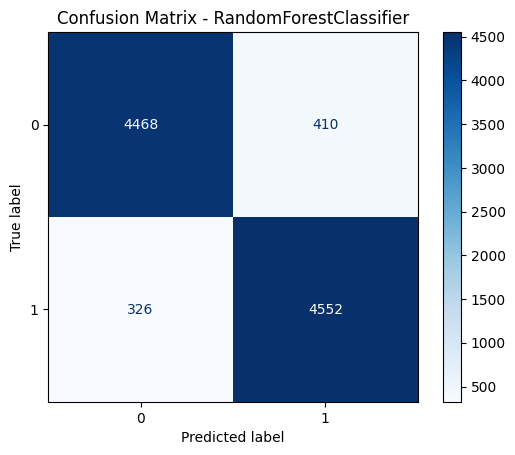

In [16]:
cm = confusion_matrix(over_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

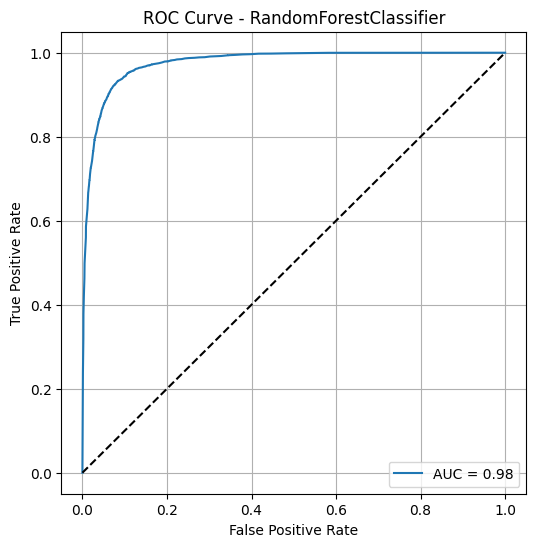

In [17]:
fpr, tpr, _ = roc_curve(over_y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [18]:
print(classification_report(over_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4878
           1       0.92      0.93      0.93      4878

    accuracy                           0.92      9756
   macro avg       0.92      0.92      0.92      9756
weighted avg       0.92      0.92      0.92      9756



# 🇺🇸 Tuning Models - 🇧🇷 Tunando Modelos

In [19]:
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


rf_model = RandomForestClassifier(random_state=42)


grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')


start_time = time.time()


grid_search_rf.fit(over_X_train, over_y_train)


end_time = time.time()
time_taken = end_time - start_time


best_rf_model = grid_search_rf.best_estimator_


print("Best parameters for RandomForestClassifier:")
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for RandomForestClassifier:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [20]:
param_grid_et = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],

}


et_model = ExtraTreesClassifier(random_state=42)


grid_search_et = GridSearchCV(estimator=et_model, param_grid=param_grid_et, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')


start_time = time.time()


grid_search_et.fit(over_X_train, over_y_train)


end_time = time.time()
time_taken = end_time - start_time


best_et_model = grid_search_et.best_estimator_


print("Best parameters for ExtraTreesClassifier:")
print(grid_search_et.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for ExtraTreesClassifier:
{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 150}


In [21]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}


dt_model = DecisionTreeClassifier(random_state=42)


grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')


start_time = time.time()


grid_search_dt.fit(over_X_train, over_y_train)


end_time = time.time()
time_taken = end_time - start_time


best_dt_model = grid_search_dt.best_estimator_


print("Best parameters for DecisionTreeClassifier:")
print(grid_search_dt.best_params_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
432 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/sklear

Best parameters for DecisionTreeClassifier:
{'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [22]:
results = []

rf_results = {
    'Model': 'RandomForestClassifier',
    'Train Accuracy': best_rf_model.score(over_X_train, over_y_train),
    'Test Accuracy': best_rf_model.score(over_X_test, over_y_test),
    'Train F1': f1_score(over_y_train, best_rf_model.predict(over_X_train)),
    'Test F1': f1_score(over_y_test, best_rf_model.predict(over_X_test)),
    'Train ROC AUC': roc_auc_score(over_y_train, best_rf_model.predict_proba(over_X_train)[:, 1]),
    'Test ROC AUC': roc_auc_score(over_y_test, best_rf_model.predict_proba(over_X_test)[:, 1]),
    'Time taken for tuning (s)': time_taken
}

results.append(rf_results)


et_results = {
    'Model': 'ExtraTreesClassifier',
    'Train Accuracy': best_et_model.score(over_X_train, over_y_train),
    'Test Accuracy': best_et_model.score(over_X_test, over_y_test),
    'Train F1': f1_score(over_y_train, best_et_model.predict(over_X_train)),
    'Test F1': f1_score(over_y_test, best_et_model.predict(over_X_test)),
    'Train ROC AUC': roc_auc_score(over_y_train, best_et_model.predict_proba(over_X_train)[:, 1]),
    'Test ROC AUC': roc_auc_score(over_y_test, best_et_model.predict_proba(over_X_test)[:, 1]),
    'Time taken for tuning (s)': time_taken
}

results.append(et_results)


dt_results = {
    'Model': 'DecisionTreeClassifier',
    'Train Accuracy': best_dt_model.score(over_X_train, over_y_train),
    'Test Accuracy': best_dt_model.score(over_X_test, over_y_test),
    'Train F1': f1_score(over_y_train, best_dt_model.predict(over_X_train)),
    'Test F1': f1_score(over_y_test, best_dt_model.predict(over_X_test)),
    'Train ROC AUC': roc_auc_score(over_y_train, best_dt_model.predict_proba(over_X_train)[:, 1]),
    'Test ROC AUC': roc_auc_score(over_y_test, best_dt_model.predict_proba(over_X_test)[:, 1]),
    'Time taken for tuning (s)': time_taken
}

results.append(dt_results)


results_df = pd.DataFrame(results)


results_df

,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC AUC,Test ROC AUC,Time taken for tuning (s)
0,RandomForestClassifier,0.994414,0.923842,0.994415,0.924469,0.999539,0.976687,6.981227
1,ExtraTreesClassifier,0.994286,0.918717,0.994285,0.918941,0.999806,0.974176,6.981227
2,DecisionTreeClassifier,0.962228,0.893091,0.962083,0.892174,0.995047,0.915538,6.981227


In [23]:
voting_clf = VotingClassifier(estimators=[
    ('rf', grid_search_rf.best_estimator_),
    ('et', grid_search_et.best_estimator_),
    ('dt', grid_search_dt.best_estimator_)
], voting='soft')

voting_clf.fit(over_X_train, over_y_train)

voting_train_accuracy = voting_clf.score(over_X_train, over_y_train)
voting_test_accuracy = voting_clf.score(over_X_test, over_y_test)

voting_train_f1 = f1_score(over_y_train, voting_clf.predict(over_X_train))
voting_test_f1 = f1_score(over_y_test, voting_clf.predict(over_X_test))

voting_train_roc_auc = roc_auc_score(over_y_train, voting_clf.predict_proba(over_X_train)[:, 1])
voting_test_roc_auc = roc_auc_score(over_y_test, voting_clf.predict_proba(over_X_test)[:, 1])

print("Voting Classifier Evaluation:")
print(f"Train Accuracy: {voting_train_accuracy}")
print(f"Test Accuracy: {voting_test_accuracy}")
print(f"Train F1: {voting_train_f1}")
print(f"Test F1: {voting_test_f1}")
print(f"Train ROC AUC: {voting_train_roc_auc}")
print(f"Test ROC AUC: {voting_test_roc_auc}")

stacking_clf = StackingClassifier(
    estimators=[('rf', grid_search_rf.best_estimator_),
                ('et', grid_search_et.best_estimator_),
                ('dt', grid_search_dt.best_estimator_)],
    final_estimator=LogisticRegression()
)


stacking_clf.fit(over_X_train, over_y_train)


stacking_train_accuracy = stacking_clf.score(over_X_train, over_y_train)
stacking_test_accuracy = stacking_clf.score(over_X_test, over_y_test)

stacking_train_f1 = f1_score(over_y_train, stacking_clf.predict(over_X_train))
stacking_test_f1 = f1_score(over_y_test, stacking_clf.predict(over_X_test))

stacking_train_roc_auc = roc_auc_score(over_y_train, stacking_clf.predict_proba(over_X_train)[:, 1])
stacking_test_roc_auc = roc_auc_score(over_y_test, stacking_clf.predict_proba(over_X_test)[:, 1])

print("\nStacking Classifier Evaluation:")
print(f"Train Accuracy: {stacking_train_accuracy}")
print(f"Test Accuracy: {stacking_test_accuracy}")
print(f"Train F1: {stacking_train_f1}")
print(f"Test F1: {stacking_test_f1}")
print(f"Train ROC AUC: {stacking_train_roc_auc}")
print(f"Test ROC AUC: {stacking_test_roc_auc}")

Voting Classifier Evaluation:
Train Accuracy: 0.9921586715867159
Test Accuracy: 0.9175891758917589
Train F1: 0.992149417620196
Test F1: 0.9178753830439224
Train ROC AUC: 0.9995681608491978
Test ROC AUC: 0.9748504972749605

Stacking Classifier Evaluation:
Train Accuracy: 0.9944136941369414
Test Accuracy: 0.924149241492415
Train F1: 0.9944139804233075
Test F1: 0.924597513755859
Train ROC AUC: 0.9996343962004606
Test ROC AUC: 0.9769626319674429


In [24]:
y_pred_stacking = stacking_clf.predict(over_X_test)

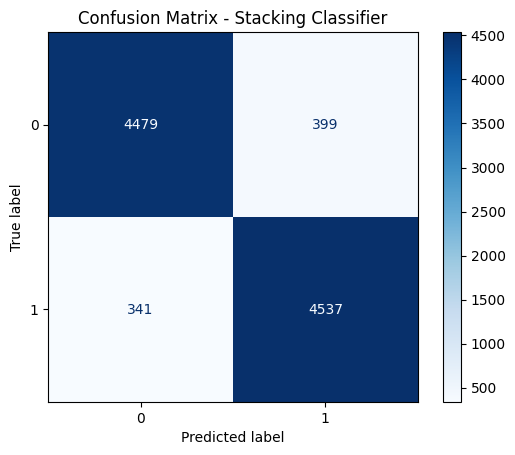

In [25]:
cm = confusion_matrix(over_y_test, y_pred_stacking)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - Stacking Classifier')
plt.show()

In [26]:
y_prob_stacking = stacking_clf.predict_proba(over_X_test)[:, 1]

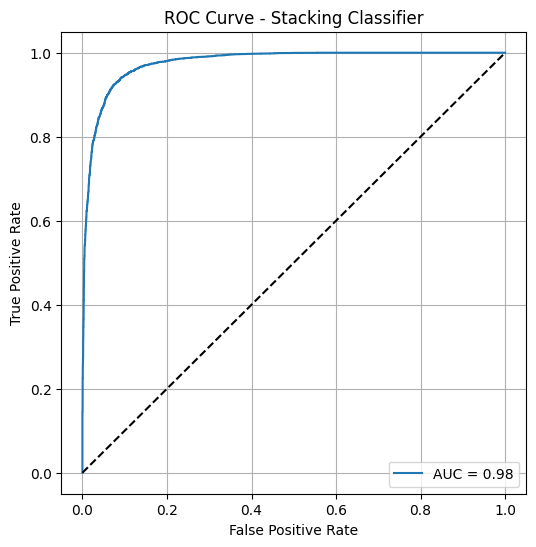

In [27]:
fpr, tpr, _ = roc_curve(over_y_test, y_prob_stacking)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Stacking Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 🇺🇸 Save The Model - 🇧🇷 Salvando o Modelo

In [ ]:
import joblib

joblib.dump(stacking_clf, '../models/stacking_model.pkl')


['../models/stacking_model.pkl']